In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

import time

from sklearn.metrics import mean_absolute_error

In [2]:
limit_ListPrice = 1800
price_segment = 30
customer_traffic_segment = 0.0833 #5/(limit_ListPrice/price_segment)
competitiveness_segment = 0.0416 #2.5/(limit_ListPrice/price_segment)
epsilon = 0.4
moving_avg_clusters= {
  "temmuz": [],
  "agustos": [],
  "eylul": [],
}

# Dynamic Pricing with Reinforcement Learning

In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
df_byclusters_train2 = np.load("/content/drive/My Drive/Colab Notebooks/dynamic_pricing/data/df_training_tae.npy", allow_pickle=True)
df_byclusters_val2 = np.load("/content/drive/My Drive/Colab Notebooks/dynamic_pricing/data/df_test_tae.npy", allow_pickle=True)

In [ ]:
print("\n***************************************************\nTraining\n***************************************************\n")
df_byclusters_train=[]
for df in df_byclusters_train2:
    df =  pd.DataFrame(df, columns =  ['DWHotelID', 'Unnamed: 0', 'w', 'Date', 'ListPriceTRY',
       'PurchaseAmountTRY', 'RatingTripA', 'ProfitRate', 'featureScore',
       'Date_year', 'Date_week', 'rooms_old', '#rooms', 'empty_rooms',
       'rewardrate'])
    print('------------------------------------------------------------------------')
    print('Max Purchase Amount:', df['PurchaseAmountTRY'].max() , 'Min Purchase Amount:', df['PurchaseAmountTRY'].min())
    print('Max List Price:', df['ListPriceTRY'].max() , 'Min List Price:', df['ListPriceTRY'].min() )
    print('Max Rate:', df['RatingTripA'].max(), 'Min Rate:', df['RatingTripA'].min())
    print('Max Feature Score:', df['featureScore'].max() , 'Min Feature Score:', df['featureScore'].min())
    print('Max Room Count:', df['empty_rooms'].max() , 'Min Room Count:', df['empty_rooms'].min())
    print('------------------------------------------------------------------------')
    df_byclusters_train.append(df)
print("\n***************************************************\nValidation\n***************************************************\n")
df_byclusters_val=[]
for df in df_byclusters_val2:
    df =  pd.DataFrame(df, columns =  ['Index', 'DWHotelID', 'Unnamed: 0', 'w', 'Date', 'ListPriceTRY',
       'PurchaseAmountTRY', 'RatingTripA', 'ProfitRate', 'featureScore',
       'Date_year', 'Date_week', 'rooms_old', '#rooms', 'empty_rooms',
       'rewardrate'])
    print('------------------------------------------------------------------------')
    print('Max Purchase Amount:', df['PurchaseAmountTRY'].max() , 'Min Purchase Amount:', df['PurchaseAmountTRY'].min())
    print('Max List Price:', df['ListPriceTRY'].max() , 'Min List Price:', df['ListPriceTRY'].min() )
    print('Max Rate:', df['RatingTripA'].max(), 'Min Rate:', df['RatingTripA'].min())
    print('Max Feature Score:', df['featureScore'].max() , 'Min Feature Score:', df['featureScore'].min())
    print('Max Room Count:', df['empty_rooms'].max() , 'Min Room Count:', df['empty_rooms'].min())
    print('------------------------------------------------------------------------')
    df_byclusters_val.append(df)

### UTILITY FUNCTIONS

In [6]:
def round_specific(x, precision, base):
  return round(base * round(float(x)/base),precision)

def round_specific_series(x, precision, base):
  return round(base * round(x/base),precision)

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def print_metrics(data_frame):

  print("*Number of Sales: ",data_frame.shape[0])
  print("*Mean Absolute Error: ", mean_absolute_error(data_frame['ListPriceTRY'],data_frame['list_price']));
 
  print("*Mean Absolute Percentage Error ", mean_absolute_percentage_error(data_frame['ListPriceTRY'],data_frame['list_price']));
 
  print("*Mean of Recommended List Prices:", data_frame['list_price'].mean())
  print("*Mean of Original List Prices:", data_frame['ListPriceTRY'].mean())

  print("*Standard Deviation of Recommended List Prices:", data_frame['list_price'].std())
  print("*Standard Deviation of Original List Prices:", data_frame['ListPriceTRY'].std())
 
  return

#### Reward Functions

In [7]:
def proposed(list_price, purchase, empty_rooms):
    return (list_price-purchase)/empty_rooms
def timestamp(list_price, purchase, empty_rooms,list_price2, purchase2, empty_rooms2):
    return (list_price2-purchase2)/empty_rooms2 - (list_price-purchase)/empty_rooms
def profit(list_price,purchase):
    return (list_price-purchase)/(purchase+0.001)

#### Draw Functions

In [8]:
def draw(moving_avg,moving_avg_val, moving_avg_all, df, validation):
    print("Validation")
    plt.rcParams['figure.figsize'] = [20, 5]
    plt.plot([i for i in range(len(moving_avg_val))], moving_avg_val)
    plt.ylabel(f"Reward 100ma")
    plt.xlabel("episode #")
    plt.show()

    validation.reset_index()
    validation = validation[['ListPriceTRY','list_price']]
    plt.figure();
    plt.rcParams['figure.figsize'] = [20, 5]
    validation.plot.area(stacked=False);
    plt.show()
    

    print("All Dataset")
    plt.rcParams['figure.figsize'] = [20, 5]
    plt.plot([i for i in range(len(moving_avg_all))],moving_avg_all)
    plt.ylabel(f"Reward 100ma")
    plt.xlabel("episode #")
    plt.show()

    df2 = pd.concat([df,validation])
    df22 = df2[['ListPriceTRY','list_price']]
    plt.figure();
    plt.rcParams['figure.figsize'] = [20, 5]
    df22.plot.area(stacked=False);
    plt.show()
    print("\n\n\|")
    print_metrics(validation)
    print("|")
    print_metrics(df2)
    print("|")
    print_metrics(df)

### AGENT CLASS: SALE
 * Initializes first list price according to purchase amount
 * Takes actions: +10%, 0, -5%

In [9]:
class Sale:
    def __init__(self, purchase, customer_traffic, competitiveness, empty_rooms):
        self.profit = round_specific(np.random.rand()*0.2, 2, 0.01)
        self.purchase = purchase
        if self.purchase > limit_ListPrice:
            self.purchase = limit_ListPrice
        if self.purchase < 0:
            self.purchase = 0
        
        self.list_price = self.purchase + self.purchase*self.profit
        self.list_price = round_specific(self.list_price, 0, price_segment)
        if self.list_price > limit_ListPrice:
            self.list_price = limit_ListPrice
        if self.list_price < 0:
            self.list_price = 0

        self.customer_traffic = customer_traffic
        self.competitiveness = competitiveness
        self.empty_rooms = empty_rooms
    
    def __str__(self):
        return f"{self.profit}"
    
    def __sub__(self,other):
        return self.profit - other.profit
    
    def action(self, choice):
        if choice == 0:
            self.change(-5) # profiti %5 indir
        elif choice == 1:
            self.change(0) 
        elif choice == 2:
            self.change(+10) 
        """
        elif choice == 3:
            self.change(+5) 
        elif choice == 4:
            self.change(+10) # profiti %10 arttir 
        """
    
    def change(self, p=False):
        if not p:
            self.profit = round_specific(np.random.rand(), 2, 0.01)
        else:
            self.profit = self.profit + (p/100)
            
        self.list_price = self.purchase + self.purchase*self.profit 
        self.list_price = round_specific(self.list_price, 0, price_segment)
        if self.list_price > limit_ListPrice:
            self.list_price = limit_ListPrice
        if self.list_price < 0:
            self.list_price = 0

### LOAD Q TABLE

In [10]:
q_table_main = np.load('/content/drive/My Drive/Colab Notebooks/dynamic_pricing/data/qtable/q_table_30_1800_3acts.npy',allow_pickle='TRUE').item()

### RL FUNCTIONS

#### 1- RL WITH PROPOSED REWARD FUNCTION

In [11]:
def RL_proposed(HM_EPISODES, epsilon, df, q_table):
    EPS_DECAY = 0.998
    SHOW_EVERY = 1
    LEARNING_RATE = 0.1
    DISCOUNT = 0.95
    df['list_price']=np.nan

    episode_rewards = []

    for episode in range(HM_EPISODES):
        # initalize agent
        sale = df.iloc[episode]
        
        purchase = sale['PurchaseAmountTRY']
        purchase = round_specific(purchase, 0, price_segment)
        
        customer_traffic = sale['RatingTripA']
        customer_traffic = round_specific(customer_traffic, 1, customer_traffic_segment)
        
        competitiveness = sale['featureScore']
        competitiveness = round_specific(competitiveness, 2, competitiveness_segment)
        
        empty_rooms = sale['empty_rooms']
        
        # get first list price 
        agent = Sale(purchase, customer_traffic, competitiveness, empty_rooms)
        
        list_price = agent.list_price

        episode_reward = 0

        for i in range(200):
            obs = (purchase, list_price, customer_traffic, competitiveness)
            
            if np.random.random() > epsilon:
                # GET THE ACTION
                action = np.argmax(q_table[obs])
            else:
                action = np.random.randint(0, 3)
            
            # Take the action!
            agent.action(action)
            
            ##############################
            # REWARD FUNCTION
            new_obs = (agent.purchase, agent.list_price, agent.customer_traffic, agent.competitiveness)
            max_future_q = np.max(q_table[new_obs])
   
            current_q = q_table[obs][action]
            
            rewardrate = proposed(agent.list_price, agent.purchase,agent.empty_rooms)
            
            if rewardrate < 1:
                reward = -300
                new_q = (1 - LEARNING_RATE) * current_q + LEARNING_RATE * (reward + DISCOUNT * max_future_q)
            elif rewardrate < 10 or rewardrate > 100:
                new_q = rewardrate
                reward = 25
            else:
                reward = -1
                new_q = (1 - LEARNING_RATE) * current_q + LEARNING_RATE * (reward + DISCOUNT * max_future_q)
            
            q_table[obs][action] = new_q

            episode_reward += reward
            if reward ==25:
                break
        df['list_price'].iloc[episode] = agent.list_price
        #print(episode_reward)
        episode_rewards.append(episode_reward)
        epsilon *= EPS_DECAY

    moving_avg = np.convolve(episode_rewards, np.ones((SHOW_EVERY,))/SHOW_EVERY, mode='valid')
    return df, moving_avg

#### RUN RL ALGORITHMS

### DRAW AND PRINT METRICS

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Validation


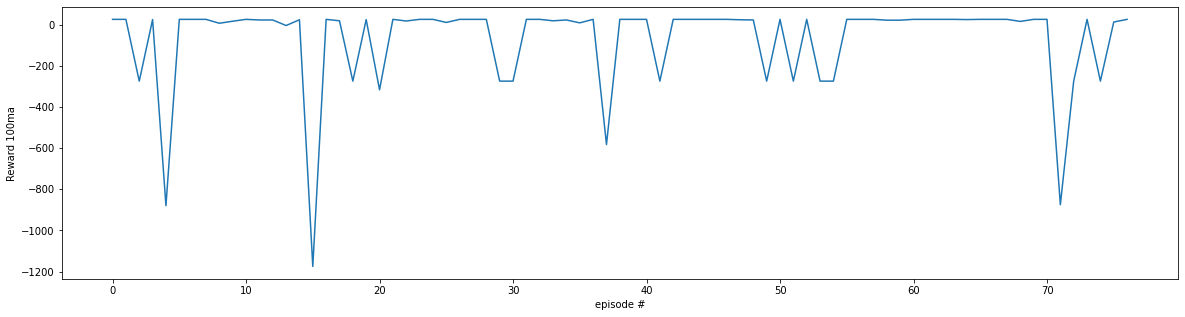

<Figure size 1440x360 with 0 Axes>

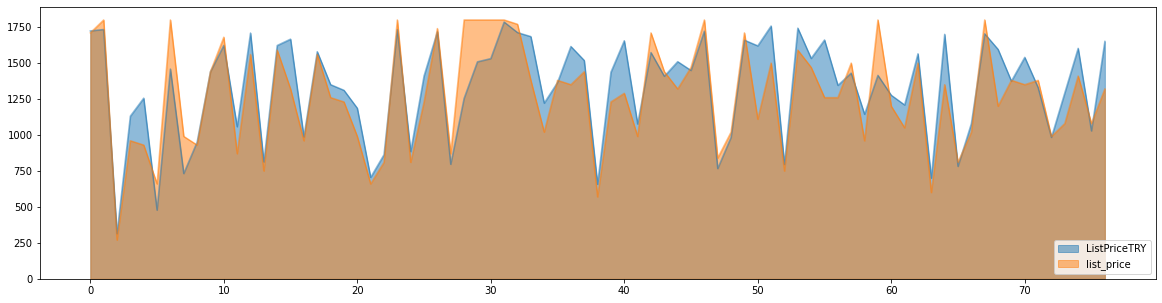

All Dataset


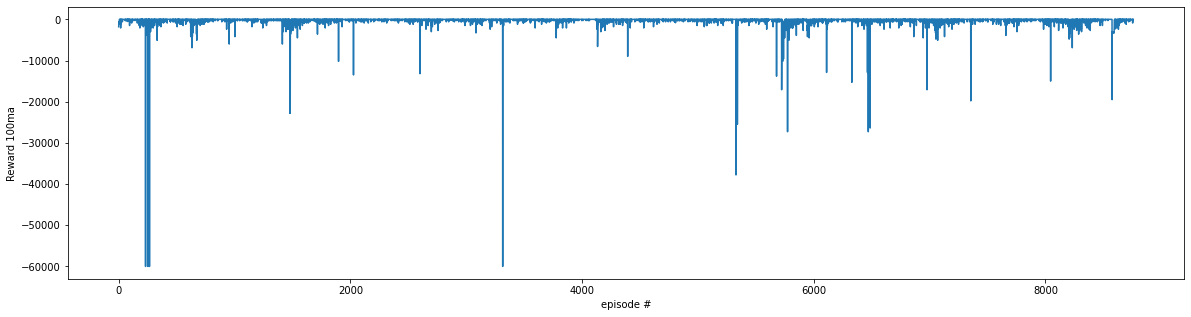

<Figure size 1440x360 with 0 Axes>

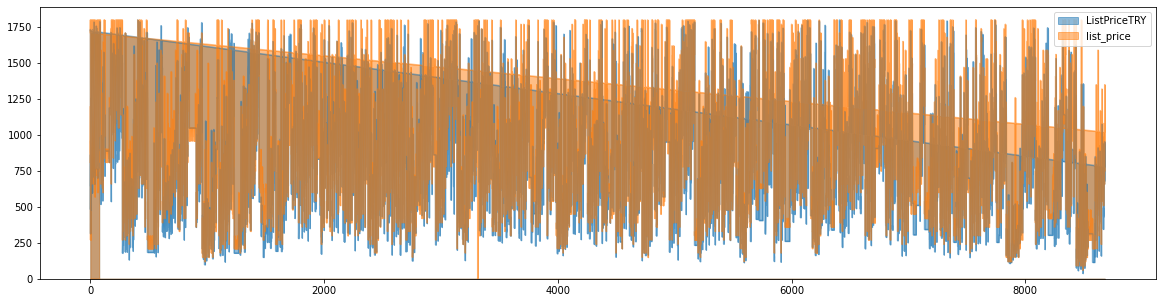



\|
*Number of Sales:  77
*Mean Absolute Error:  144.43904089838688
*Mean Absolute Percentage Error  11.144368884964551
*Mean of Recommended List Prices: 1270.5194805194806
*Mean of Original List Prices: 1327.0664312028603
*Standard Deviation of Recommended List Prices: 369.3447117028812
*Standard Deviation of Original List Prices: 357.45086457853324
|
*Number of Sales:  8759
*Mean Absolute Error:  132.10849120226746
*Mean Absolute Percentage Error  20.336470045999885
*Mean of Recommended List Prices: 859.9440575408152
*Mean of Original List Prices: 781.8926231280227
*Standard Deviation of Recommended List Prices: 431.03158210970776
*Standard Deviation of Original List Prices: 417.30281344836277
|
*Number of Sales:  8682
*Mean Absolute Error:  131.99913249153246
*Mean Absolute Percentage Error  20.417994094537057
*Mean of Recommended List Prices: 856.3026952315134
*Mean of Original List Prices: 777.0575179423784
*Standard Deviation of Recommended List Prices: 429.8062181418873
*Standa

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Validation


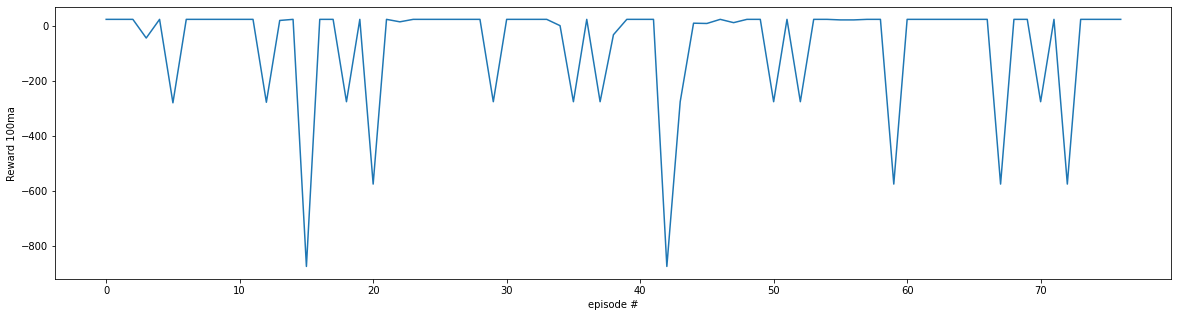

<Figure size 1440x360 with 0 Axes>

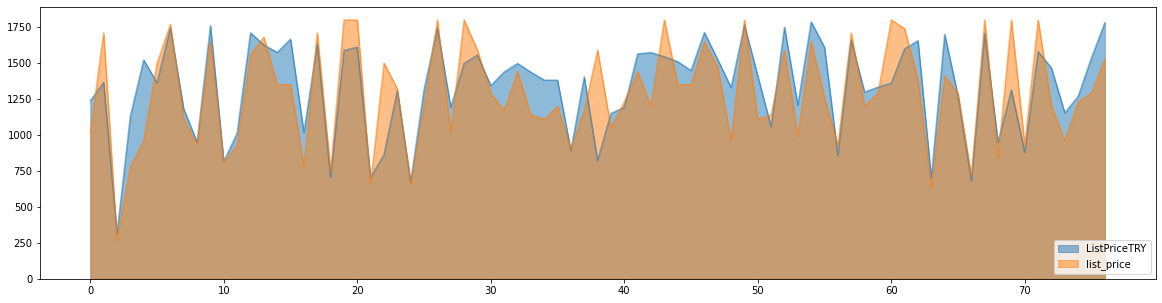

All Dataset


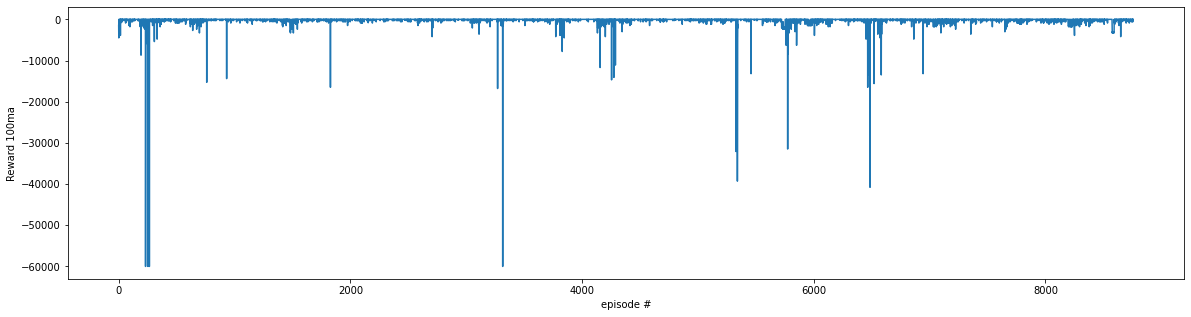

<Figure size 1440x360 with 0 Axes>

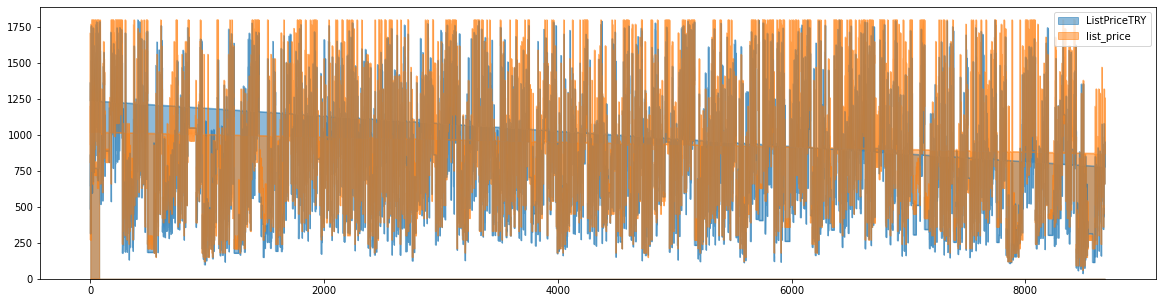



\|
*Number of Sales:  77
*Mean Absolute Error:  174.31815753187018
*Mean Absolute Percentage Error  13.560182917581406
*Mean of Recommended List Prices: 1289.6103896103896
*Mean of Original List Prices: 1336.0719836043743
*Standard Deviation of Recommended List Prices: 363.7792909474296
*Standard Deviation of Original List Prices: 333.7618094740316
|
*Number of Sales:  8759
*Mean Absolute Error:  133.65023283328966
*Mean Absolute Percentage Error  20.409313476698962
*Mean of Recommended List Prices: 863.4444571298094
*Mean of Original List Prices: 781.8926231280224
*Standard Deviation of Recommended List Prices: 433.5418928046842
*Standard Deviation of Original List Prices: 417.30281344836277
|
*Number of Sales:  8682
*Mean Absolute Error:  133.28955209131885
*Mean Absolute Percentage Error  20.470057896539103
*Mean of Recommended List Prices: 859.6648237733241
*Mean of Original List Prices: 776.9776483806509
*Standard Deviation of Recommended List Prices: 432.25220421582316
*Standar

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Validation


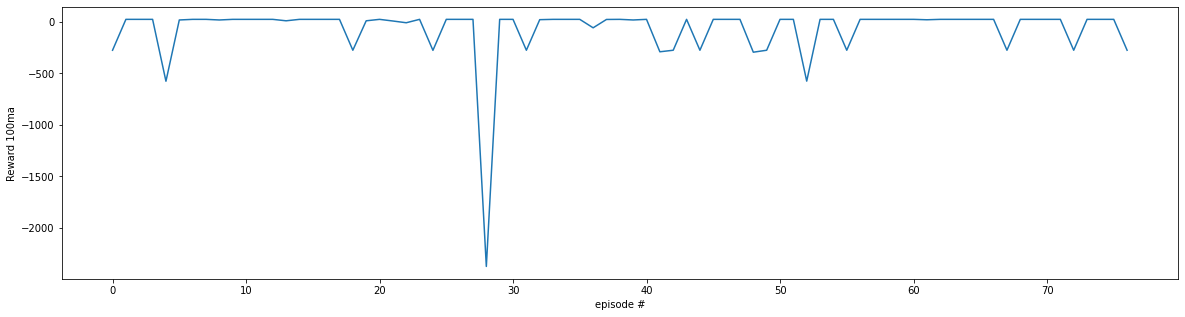

<Figure size 1440x360 with 0 Axes>

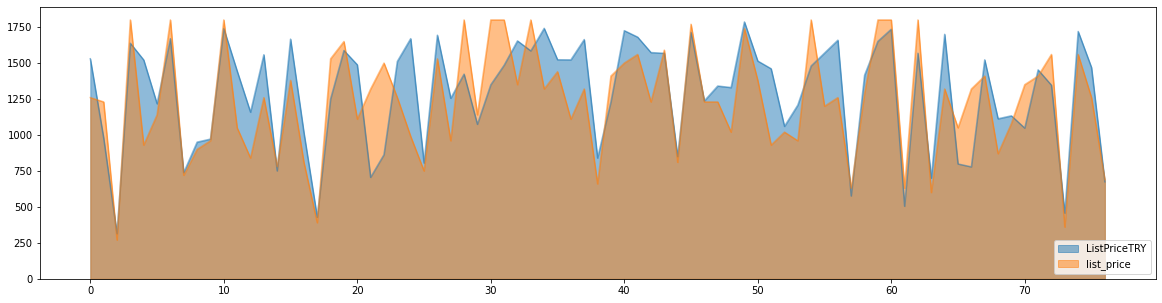

All Dataset


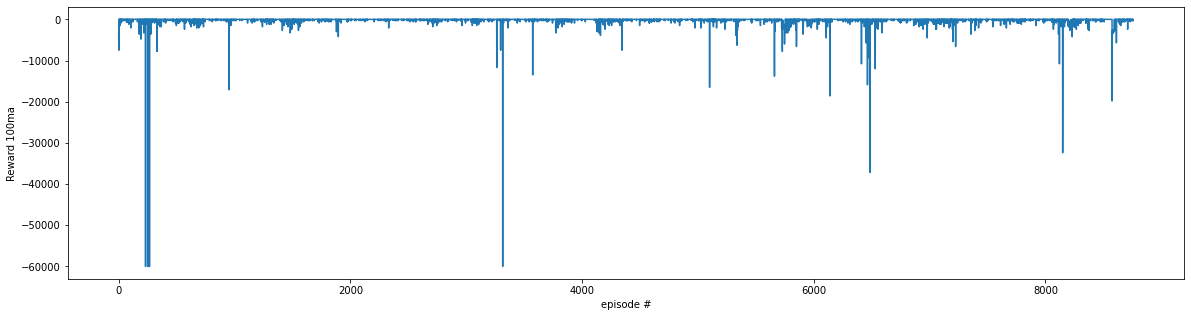

<Figure size 1440x360 with 0 Axes>

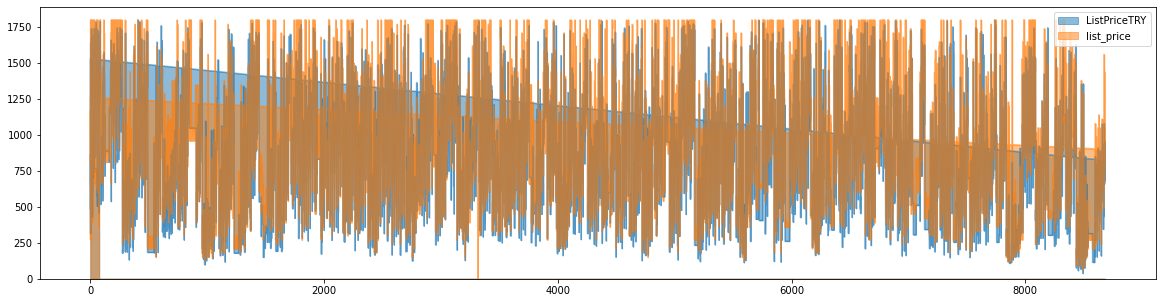



\|
*Number of Sales:  77
*Mean Absolute Error:  218.26179176838045
*Mean Absolute Percentage Error  17.685189546335145
*Mean of Recommended List Prices: 1232.3376623376623
*Mean of Original List Prices: 1290.071358316172
*Standard Deviation of Recommended List Prices: 390.32677303394786
*Standard Deviation of Original List Prices: 386.0085868932924
|
*Number of Sales:  8759
*Mean Absolute Error:  134.72947888057
*Mean Absolute Percentage Error  20.70903252079586
*Mean of Recommended List Prices: 864.5952734330403
*Mean of Original List Prices: 781.8926231280223
*Standard Deviation of Recommended List Prices: 432.5658773067196
*Standard Deviation of Original List Prices: 417.30281344836277
|
*Number of Sales:  8682
*Mean Absolute Error:  133.98863712839753
*Mean Absolute Percentage Error  20.73585075496235
*Mean of Recommended List Prices: 861.3337940566689
*Mean of Original List Prices: 777.3856244399908
*Standard Deviation of Recommended List Prices: 431.5425025835742
*Standard Devi

In [12]:
moving_avg_byclusters_train = []
moving_avg_byclusters_val = []

for i in range(3):
    q_table = q_table_main.copy()
    df_byclusters_train[i].reset_index()
    df_byclusters_train[i], moving_avg_train = RL_proposed(df_byclusters_train[i].shape[0], epsilon, df_byclusters_train[i], q_table)

    moving_avg_byclusters_train.append(moving_avg_train)

    
    df_byclusters_val[i], moving_avg_val = RL_proposed(df_byclusters_val[i].shape[0], epsilon, df_byclusters_val[i], q_table)

    moving_avg_byclusters_val.append(moving_avg_val)

    moving_avg_clusters[list(moving_avg_clusters.keys())[i]] =[moving_avg_train, moving_avg_val]

    draw(moving_avg_train,
         moving_avg_val, 
         np.concatenate([moving_avg_train, moving_avg_val]), 
         df_byclusters_train[i],  
         df_byclusters_val[i])


In [15]:
moving_avg_cluster={}
moving_avg_cluster['temmmuz'] = moving_avg_clusters['agustos']
moving_avg_cluster['agustos'] = moving_avg_clusters['eylul']
moving_avg_cluster['eylul'] = moving_avg_clusters['temmuz']
moving_avg_cluster

{'agustos': [array([-4775.,    25., -1775., ...,  -575.,    25.,    25.]),
  array([ -275.,    25.,    25.,    25.,  -576.,    19.,    25.,    25.,
            19.,    25.,    25.,    25.,    25.,    11.,    25.,    25.,
            25.,    25.,  -275.,    11.,    25.,     9.,    -8.,    25.,
          -276.,    25.,    25.,    25., -2375.,    25.,    25.,  -275.,
            22.,    25.,    25.,    25.,   -57.,    24.,    25.,    19.,
            25.,  -290.,  -275.,    25.,  -275.,    25.,    25.,    25.,
          -294.,  -275.,    25.,    25.,  -575.,    25.,    25.,  -275.,
            25.,    25.,    25.,    25.,    25.,    21.,    25.,    25.,
            25.,    25.,    25.,  -275.,    25.,    25.,    25.,    25.,
          -275.,    25.,    25.,    25.,  -275.])],
 'eylul': [array([-1775.,  -875.,  -875., ...,    25.,    25.,    25.]),
  array([   25.,    25.,  -275.,    24.,  -880.,    25.,    25.,    25.,
             6.,    16.,    25.,    22.,    22.,    -5.,    23., -1175

In [16]:
np.save('/content/drive/My Drive/Colab Notebooks/dynamic_pricing/results/moving_avg_clusters_tae.npy',moving_avg_cluster)